In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
from scipy.interpolate import griddata
import csv

%run -i storm_coords.py

In [3]:
# some helper routines used below
def report_spacing( lat, lon):
    spacing = [0.]
    for i in range(len(lat)-1):
        spacing.append( haversine(lon[i], lat[i], lon[i+1], lat[i+1] ) )
    print('Npts: ',len(spacing))
    print('Mean spacing (km): ',np.mean(spacing))
    print('Max. spacing (km): ',np.max(spacing))
    # Find the gaps
    print('Gaps: ',np.argwhere(np.array(spacing) >15.))


def subsample_contour(contour, spacing_km=11.0, radius=6371.0):
    """
    Subsample a contour to ensure points are at least `spacing_km` apart.

    Args:
        contour: Nx2 array of lat, lon points.
        spacing_km: Minimum spacing between points in km.
        radius: Earth radius in km (default 6371 km).

    Returns:
        Subsampled contour (Nx2 array).
    """
    subsampled = [contour[0]]  # Start with the first point
    ssamp_idx = [0]
    for i, point in enumerate( contour[1:]) :
        last_point = subsampled[-1]
        dist = haversine(last_point[1], last_point[0], point[1], point[0], radius=radius)
        if dist >= spacing_km:
            #print('saving this one', dist, point)
            subsampled.append(point)
            ssamp_idx.append(i)
    return np.array(subsampled), ssamp_idx


def combined_distance(lat1, lon1, h1, lat2, lon2, h2, radius=6371.0, depth_weight=0.1):
    """
    Compute a weighted distance combining horizontal and depth differences.
    Horizontal distance is in kilometers, depth is in meters.
    
    Input:
        lat1, lon1, h1: Reference lat, lon, and depth.
        lat2, lon2, h2: Candidate lat, lon, and depth arrays.
        radius: Earth radius in km (default 6371 km).
        depth_weight: Weight for depth differences relative to horizontal.

    Returns:
        Combined distance (horizontal + depth differences).
    """
    # Horizontal distance (Haversine)
    horizontal_dist = haversine(lon1, lat1, lon2, lat2, radius=radius)
    
    # Depth difference
    depth_diff = np.abs(h1 - h2)
    
    # Weighted Euclidean distance
    return np.sqrt(horizontal_dist**2 + (depth_weight * depth_diff)**2)


In [19]:
# Load the contour file
contour_file = 'contour15sp.csv'
df = pd.read_csv( contour_file )
contour15sp = np.column_stack( (df['contour15s_lon'], df['contour15s_lat']) )
normals = np.column_stack( (df['normals_x'], df['normals_y']) )
df

,contour15s_lon,contour15s_lat,contour15s_x,contour15s_y,normals_x,normals_y
0,-90.294734,28.974981,-407646.233968,3.241079e+06,-0.332859,0.942977
1,-90.255936,28.990147,-403706.301715,3.242470e+06,-0.329871,0.944026
2,-90.217015,29.005087,-399757.645119,3.243836e+06,-0.322291,0.946641
3,-90.177917,29.019686,-395795.934747,3.245163e+06,-0.311229,0.950335
4,-90.138583,29.033805,-391816.527119,3.246436e+06,-0.296066,0.955168
...,...,...,...,...,...,...
307,-81.840160,24.968208,415195.954412,2.761690e+06,0.988946,-0.148274
308,-81.847158,24.931025,414463.853669,2.757577e+06,0.979057,-0.203588
309,-81.856493,24.894273,413495.622850,2.753513e+06,0.965412,-0.260727
310,-81.868212,24.858094,412286.397911,2.749514e+06,0.947985,-0.318316


In [10]:
# Read the wave model history file...this has higher density fields for depth and bulk model results
his_url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'
ds_his = xr.open_dataset(his_url)
ds_his

<xarray.Dataset> Size: 32GB
Dimensions:          (tracer: 2, s_rho: 16, s_w: 17, eta_rho: 512, xi_rho: 833,
                      eta_u: 512, xi_u: 832, eta_v: 511, xi_v: 833,
                      eta_psi: 511, xi_psi: 832, ocean_time: 121)
Coordinates:
  * s_rho            (s_rho) float64 128B -0.9688 -0.9062 ... -0.09375 -0.03125
  * s_w              (s_w) float64 136B -1.0 -0.9375 -0.875 ... -0.0625 0.0
    lon_rho          (eta_rho, xi_rho) float64 3MB ...
    lat_rho          (eta_rho, xi_rho) float64 3MB ...
    lon_u            (eta_u, xi_u) float64 3MB ...
    lat_u            (eta_u, xi_u) float64 3MB ...
    lon_v            (eta_v, xi_v) float64 3MB ...
    lat_v            (eta_v, xi_v) float64 3MB ...
    lon_psi          (eta_psi, xi_psi) float64 3MB ...
    lat_psi          (eta_psi, xi_psi) float64 3MB ...
  * ocean_time       (ocean_time) datetime64[ns] 968B 2024-09-24 ... 2024-09-29
Dimensions without coordinates: tracer, eta_rho, xi_rho, eta_u, xi_u, eta_v,
                                xi_v, eta_psi, xi_psi
Data variables: (12/113)
    ntimes           int32 4B ...
    ndtfast          int32 4B ...
    dt               float64 8B ...
    dtfast           float64 8B ...
    dstart           datetime64[ns] 8B ...
    nHIS             int32 4B ...
    ...               ...
    Lwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Lwavep           (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_top        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_bot        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Uwave_rms        (ocean_time, eta_rho, xi_rho) float32 206MB ...
Attributes: (12/33)
    file:                            Output/coawst_gomsab_his.nc
    format:                          netCDF-3 64bit offset file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           COAWST ROMS SWAN
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 4.1, Wednesday - Octo...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     COAWST, ANA_BSFLUX, ANA_BTFLUX, ANA_FSOB...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               16
    EXTRA_DIMENSION.boundary:        4

In [14]:
print( ds_his['lat_rho'][0][0].values, ds_his['lat_rho'][0][-1].values )
print( ds_his['lat_rho'][-1][0].values, ds_his['lat_rho'][-1][-1].values )
print( ds_his['lat_rho'][0][0].values, ds_his['lat_rho'][0][832].values )
print( ds_his['lat_rho'][511][0].values, ds_his['lat_rho'][511][832].values )

print( ds_his['lon_rho'][0][0].values, ds_his['lon_rho'][0][-1].values )
print( ds_his['lon_rho'][-1][0].values, ds_his['lon_rho'][-1][-1].values )
print( ds_his['lon_rho'][0][0].values, ds_his['lon_rho'][0][832].values )
print( ds_his['lon_rho'][511][0].values, ds_his['lon_rho'][511][832].values )

20.852134446132126 26.529261583412453
30.34763307220233 35.89691943750916
20.852134446132126 26.529261583412453
30.34763307220233 35.89691943750916
-87.02097037489125 -74.49467236474399
-91.1418732177684 -78.51723615225691
-87.02097037489125 -74.49467236474399
-91.1418732177684 -78.51723615225691


In [15]:
# Load the dataset containing spec2d model results
# Puget WS
#url = 'D:/crs/proj/2025_NOPP_comparison/helene_waves/helene_swan_kom_efth.nc'
#  Dell WS
url = "F:/crs/proj/2025_NOPP_comparison/helene_waves/helene_swan_kom_efth.nc"
ds = xr.open_dataset(url)
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 121, lat: 71, lon: 40, freq: 25, dir: 60)
Coordinates:
  * time     (time) datetime64[ns] 968B 2024-09-24 ... 2024-09-29
  * lat      (lat) float64 568B 23.0 23.1 23.2 23.3 23.4 ... 29.7 29.8 29.9 30.0
  * lon      (lon) float64 320B -86.5 -86.4 -86.3 -86.2 ... -82.8 -82.7 -82.6
  * freq     (freq) float64 200B 0.04 0.0457 0.0523 0.0598 ... 0.7647 0.8745 1.0
  * dir      (dir) float64 480B 3.0 9.0 15.0 21.0 ... 339.0 345.0 351.0 357.0
Data variables:
    efth     (time, lat, lon, freq, dir) float64 4GB ...

In [16]:
# I can't remember why I am doing all this
# Extract lat/lon from `ds_his` (h's grid)
lat_his = ds_his['lat_rho'].values  # Shape (512, 833)
lon_his = ds_his['lon_rho'].values  # Shape (512, 833)
depth_h = ds_his['h'].values        # Shape (512, 833)

# Flatten the lat/lon grid for interpolation
lat_his_flat = lat_his.ravel()
lon_his_flat = lon_his.ravel()
depth_h_flat = depth_h.ravel()

# Create meshgrid for the target `ds` lat/lon
lat_ds = ds['lat'].values
lon_ds = ds['lon'].values
lon_mesh, lat_mesh = np.meshgrid(lon_ds, lat_ds)

# Interpolate depth values onto `ds` grid
h_interp = griddata(
    (lon_his_flat, lat_his_flat),  # Source points (flattened lon/lat)
    depth_h_flat,                  # Source values (flattened depth)
    (lon_mesh, lat_mesh),          # Target grid
    method='linear'                # Interpolation method
)

# Extract lat/lon from `ds_his` (h's grid)
lat_his = ds_his['lat_rho'].values  # Shape (512, 833)
lon_his = ds_his['lon_rho'].values  # Shape (512, 833)
depth_h = ds_his['h'].values        # Shape (512, 833)

# Flatten the lat/lon grid for interpolation
lat_his_flat = lat_his.ravel()
lon_his_flat = lon_his.ravel()
depth_h_flat = depth_h.ravel()

# Create meshgrid for the target `ds` lat/lon
lat_ds = ds['lat'].values
lon_ds = ds['lon'].values
lon_mesh, lat_mesh = np.meshgrid(lon_ds, lat_ds)

# Interpolate depth values onto `ds` grid
h_interp = griddata(
    (lon_his_flat, lat_his_flat),  # Source points (flattened lon/lat)
    depth_h_flat,                  # Source values (flattened depth)
    (lon_mesh, lat_mesh),          # Target grid
    method='linear'                # Interpolation method
)

# Convert to xarray.DataArray for consistency
h_da = xr.DataArray(
    h_interp,
    coords={"lat": lat_ds, "lon": lon_ds},
    dims=("lat", "lon"),
    name="water_depth"
)

# Convert to xarray.DataArray for consistency
h_da = xr.DataArray(
    h_interp,
    coords={"lat": lat_ds, "lon": lon_ds},
    dims=("lat", "lon"),
    name="water_depth"
)

# Result is now in `h_da` and can be accessed as a NumPy array or xarray
h_da


<xarray.DataArray 'water_depth' (lat: 71, lon: 40)> Size: 23kB
array([[ 745.32418878,  901.17174429, 1049.16081668, ...,  111.41679675,
          94.75692197,   73.76256225],
       [ 826.34019359, 1001.95262415, 1192.48821586, ...,  396.12191495,
         330.14904006,  241.70188718],
       [ 916.70768801, 1133.39770285, 1447.49560288, ...,  998.46119852,
         860.49089877,  678.43667462],
       ...,
       [ 108.28663679,   92.01269936,   75.83331435, ...,    5.00000001,
           5.        ,    5.        ],
       [  84.33390679,   73.69677956,   64.1047319 , ...,    5.        ,
           5.        ,    5.        ],
       [  60.41982801,   55.16467878,   48.89899495, ...,    5.        ,
           5.        ,    5.        ]])
Coordinates:
  * lat      (lat) float64 568B 23.0 23.1 23.2 23.3 23.4 ... 29.7 29.8 29.9 30.0
  * lon      (lon) float64 320B -86.5 -86.4 -86.3 -86.2 ... -82.8 -82.7 -82.6

In [17]:
# Calculate the along-contour distance
contour_dist = np.zeros_like(contour15sp[:,0])
for i in np.arange(2, len(contour15sp)):
    contour_dist[i] = contour_dist[i-1] + \
        haversine(contour15sp[i-1,1], contour15sp[i-1,0], contour15sp[i,1], contour15sp[i,0])

print('contour15sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(contour_dist), np.min(contour_dist), np.max(contour_dist) ) )

contour15sp spacing: mean 561.8, min 0.0 max 955.0


In [20]:
# Flatten the efth mesh for easier processing
model_shape = np.shape(lat_mesh)
print('model shape: ',model_shape)
lat_flat = lat_mesh.ravel()
lon_flat = lon_mesh.ravel()
h_flat = h_da.values.ravel()  # Ensure depths align with the mesh
i_flat = np.arange(len(h_flat)).astype(int) # Make index of flattened mesh

# Initialize lists for points selected from the efth grid
selected_points = []
selected_normals = []
selected_dist = []

# List for index into flattened mesh
selected_idx = []
spacing_km = 0

# Iterate through the subsampled contour
depth_weight = 1  # 1 results in 1 m = 1 km
for i, (lon_c, lat_c) in enumerate(contour15sp):
    min_dist = np.inf
    selected_point = None
    
    # Compute distances to all points in the dataset
    distances = combined_distance(
        lon_c, lat_c, 15.0,  # Contour lat, lon, target depth
        lon_flat, lat_flat, h_flat,
        depth_weight=depth_weight
    )

    # Find the closest point
    closest_idx = np.argmin(distances)
    min_dist = distances[closest_idx]
    min_idx = i_flat[closest_idx]
    
    # threshold for distance. This includes the with depth_weight
    mxd = 20
    if (min_dist <= mxd) and not (min_idx in selected_idx ) : # keep the point
        selected_point = (lat_flat[closest_idx], lon_flat[closest_idx], h_flat[closest_idx])  
        # Store the selected point and its normal angle
        selected_points.append(selected_point)
        selected_normals.append(normals[i])
        selected_dist.append(contour_dist[i])
        selected_idx.append(min_idx)

# Convert to arrays
selected_points = np.array(selected_points)  # Shape: (N, 3)
selected_normals = np.array(selected_normals)
selected_dist = np.array(selected_dist)

model shape:  (71, 40)


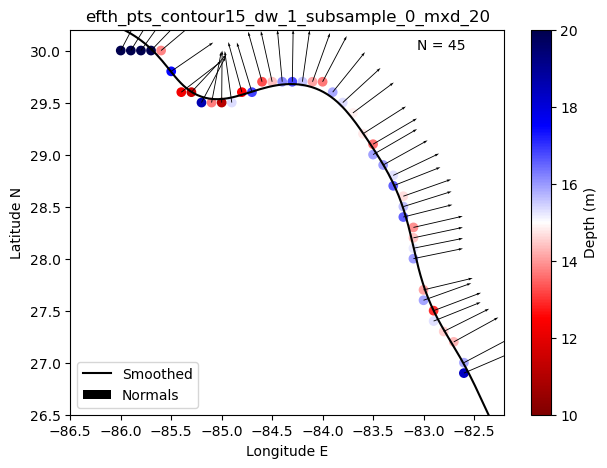

In [22]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(contour15sp[:, 0], contour15sp[:, 1], 'k-', label='Smoothed')  # Longitude vs Latitude

m = plt.scatter( selected_points[:,1], selected_points[:,0], c=selected_points[:,2], cmap='seismic_r', vmin=10., vmax=20.)
plt.quiver(
    selected_points[:, 1], selected_points[:, 0], selected_normals[:, 0], selected_normals[:, 1],
    color='k', angles='xy', scale_units='xy', scale=2, width=.002, label='Normals'
)
plt.colorbar(m, label='Depth (m)')
npts = len(selected_points)
figname = 'efth_pts_contour15_dw_{}_subsample_{}_mxd_{}'.format(depth_weight, spacing_km, mxd)
txt = 'N = {}'.format(npts)
ax.text(.8,.95,txt,transform=ax.transAxes)
plt.ylabel('Latitude N')
plt.xlabel('Longitude E')
plt.xlim(-86.5,-82.2)
plt.ylim(26.5, 30.2)
plt.title(figname)
plt.legend()
plt.savefig( figname+'.png', dpi=200, bbox_inches='tight')

Text(0.5, 0, 'Along-contour distance (km)')

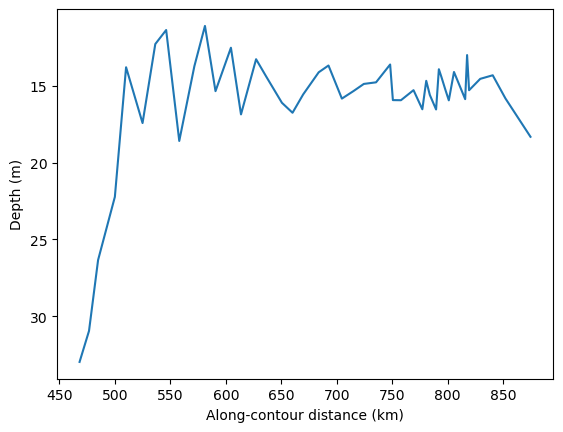

In [23]:
# plot depths v. along-contour distance
fig, ax = plt.subplots()
ax.plot(selected_dist, selected_points[:,2])
ax.invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Along-contour distance (km)')

In [62]:
rows, cols = np.unravel_index(selected_idx, model_shape)
for i, (r, c) in enumerate(zip(rows, cols)):
    print(f"Flattened index {selected_idx[i]} → 2D index ({r}, {c})")

Flattened index 2805 → 2D index (70, 5)
Flattened index 2806 → 2D index (70, 6)
Flattened index 2807 → 2D index (70, 7)
Flattened index 2808 → 2D index (70, 8)
Flattened index 2809 → 2D index (70, 9)
Flattened index 2730 → 2D index (68, 10)
Flattened index 2651 → 2D index (66, 11)
Flattened index 2652 → 2D index (66, 12)
Flattened index 2613 → 2D index (65, 13)
Flattened index 2614 → 2D index (65, 14)
Flattened index 2615 → 2D index (65, 15)
Flattened index 2616 → 2D index (65, 16)
Flattened index 2657 → 2D index (66, 17)
Flattened index 2658 → 2D index (66, 18)
Flattened index 2699 → 2D index (67, 19)
Flattened index 2700 → 2D index (67, 20)
Flattened index 2701 → 2D index (67, 21)
Flattened index 2702 → 2D index (67, 22)
Flattened index 2703 → 2D index (67, 23)
Flattened index 2704 → 2D index (67, 24)
Flattened index 2705 → 2D index (67, 25)
Flattened index 2666 → 2D index (66, 26)
Flattened index 2627 → 2D index (65, 27)
Flattened index 2588 → 2D index (64, 28)
Flattened index 2509 